# Train Spacenet from snapshot on a single case

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import cv2
import numpy as np
from PIL import Image
import sys

In [5]:
sys.path.append('/home/catskills/Desktop/xview2-catskills/utils')

In [6]:
import chainer
import chainer.functions as F
from chainer import cuda, serializers, Variable
from inference import inference
output='foo.json'

## First do inference inside notebook to see how to apply the net

In [7]:
import cv2
import numpy as np
from PIL import Image
import sys
import chainer
import chainer.functions as F
from chainer import cuda, serializers, Variable
from segmentation import SegmentationModel as Model

input='/home/catskills/Desktop/dataxv2/xBD/santa-rosa-wildfire/images/santa-rosa-wildfire_00000030_pre_disaster.png'
trainfn='/home/catskills/Desktop/dataxv2/xBD/santa-rosa-wildfire/masks/santa-rosa-wildfire_00000030_pre_disaster.png'
weights='/home/catskills/Desktop/dataxv2/release/v_catskills_0.2.1/localization.hdf5'
mean='/home/catskills/Desktop/xview2-catskills/weights/mean.npy'
sys.path.append('../src/models')
mean = np.load(mean)
model = Model(weights, mean)
image = np.array(Image.open(input))
train=np.array(Image.open(trainfn))

In [8]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [9]:
train = rgb2gray(np.array(Image.open(trainfn)))>0.5

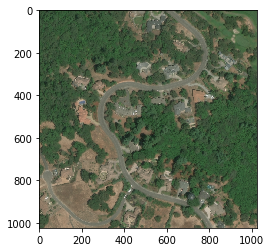

In [27]:
plt.imshow(image);

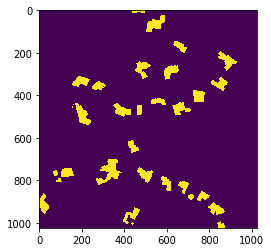

In [26]:
plt.imshow(train);

In [13]:
score = model.apply_segmentation(image)

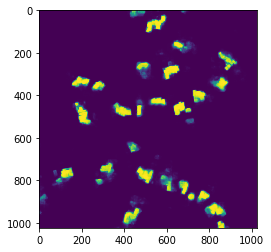

In [21]:
plt.imshow(score[1]);

In [28]:
building_mask_pred = (np.argmax(score, axis=0) == 1)

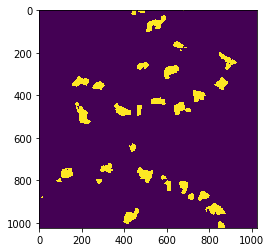

In [30]:
plt.imshow(building_mask_pred);

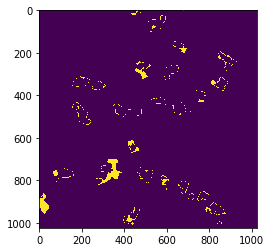

In [34]:
diff=train^building_mask_pred
plt.imshow(diff);

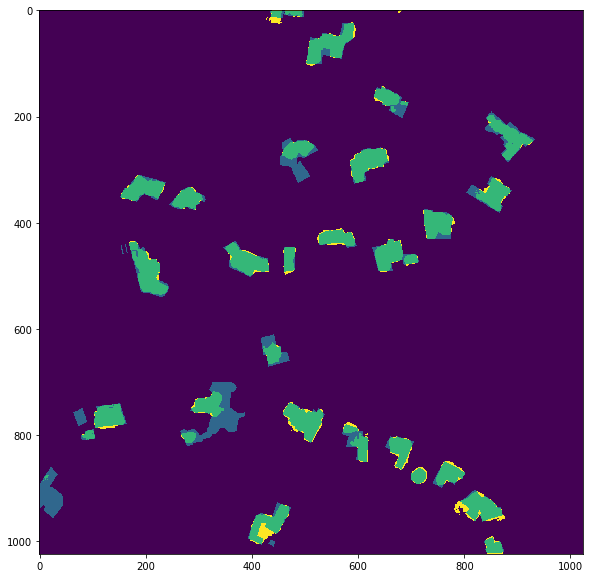

In [43]:
bm_only = (building_mask_pred & ~train).astype(int)*9
train_only=(train & ~building_mask_pred).astype(int)*3
bm_and_tr=(building_mask_pred & train).astype(int)*6
all = bm_only + train_only + bm_and_tr
plt.figure(figsize=(10,10));
plt.imshow(all);

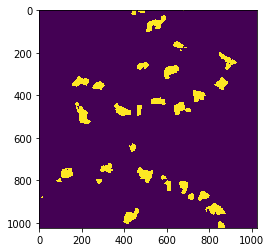

In [44]:
plt.imshow(building_mask_pred);

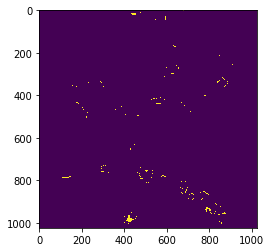

In [45]:
plt.imshow(building_mask_pred & ~train);

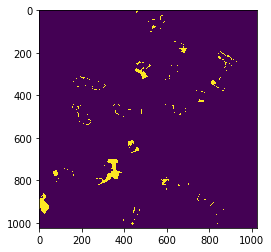

In [46]:
plt.imshow(~building_mask_pred & train);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


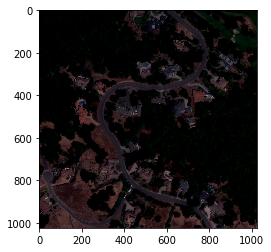

In [47]:
plt.imshow((image-mean)/255.);

## Overtrain Santa Rosa 30

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
import sys
import numpy as np
from PIL import Image
import chainer
import chainer.functions as F
from chainer import cuda, serializers, Variable
sys.path.append('../src/models')
from segmentation import SegmentationModel as Model

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def float_to_cpu(x):
    return float(cuda.to_cpu(x.data))

weights='/home/catskills/Desktop/dataxv2/release/v_catskills_0.0.0/localization.hdf5'
mean='/home/catskills/Desktop/xview2-catskills/weights/mean.npy'
mean = np.load(mean)
model = Model(weights, mean)

optimizer = chainer.optimizers.Adam()
optimizer.setup(model._SegmentationModel__model);

input='/home/catskills/Desktop/dataxv2/xBD/santa-rosa-wildfire/images/santa-rosa-wildfire_00000030_pre_disaster.png'
image = np.array(Image.open(input))
image_in, crop = model._SegmentationModel__preprocess(image)

trainfn='/home/catskills/Desktop/dataxv2/xBD/santa-rosa-wildfire/masks/santa-rosa-wildfire_00000030_pre_disaster.png'
train = rgb2gray(np.array(Image.open(trainfn)))>0.5
train_int = train.astype(int)
gt=np.array([train_int])
gt_in = Variable(cuda.cupy.asarray(gt, dtype=cuda.cupy.int))

for i in range(2000):
    with chainer.using_config('train', True):
        score_cuda= model._SegmentationModel__model.forward(image_in)
        loss = F.softmax_cross_entropy(score_cuda, gt_in)
        accuracy=float_to_cpu(F.accuracy(score_cuda, gt_in))
        if i % 100 == 0:
            print(f'[{i}] loss {100*float_to_cpu(loss):.1f}% accuracy {100*accuracy:.1f}%')
        model._SegmentationModel__model.cleargrads()
        loss.backward()
        optimizer.update()

In [38]:
from chainer import serializers
new_weights='model_updated.hdf5'
serializers.save_npz(new_weights, model._SegmentationModel__model)

In [35]:
import chainer.computational_graph as c
g = c.build_computational_graph(score_cuda)
with open('loss.dot', 'w') as o:
    o.write(g.dump())

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

with chainer.using_config('train', True):
    score_cuda= model._SegmentationModel__model.forward(image_in)
score_cuda_softmax = F.softmax(score_cuda)
score_cpu = cuda.to_cpu(score_cuda_softmax.data)[0]
top, left, bottom, right = crop
score_cpu = score_cpu[:, top:bottom, left:right]
building_mask_pred = (np.argmax(score_cpu, axis=0) == 1)

bm_only = (building_mask_pred & ~train).astype(int)*9
train_only=train & ~building_mask_pred.astype(int)*3
bm_and_tr=(building_mask_pred & train).astype(int)*6
all = bm_only + train_only + bm_and_tr
plt.figure(figsize=(10,10));
plt.imshow(all)

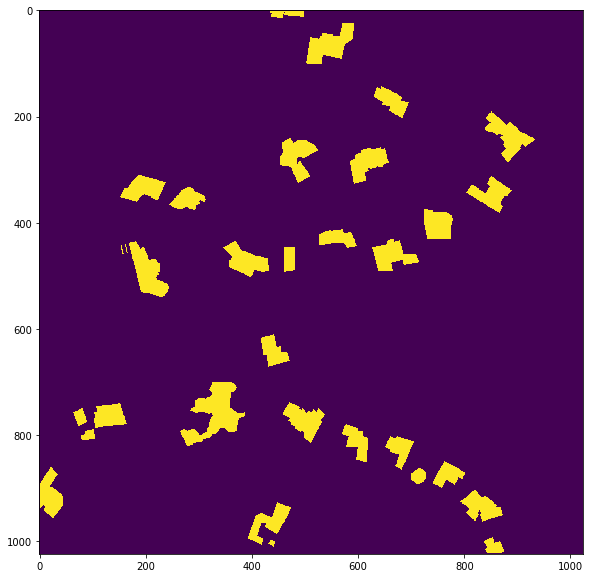

In [46]:
plt.figure(figsize=(10,10));
plt.imshow(all)

In [ ]:
plt.imshow(building_mask_pred)

plt.imshow(building_mask_pred & ~train);

plt.imshow(~building_mask_pred & train);

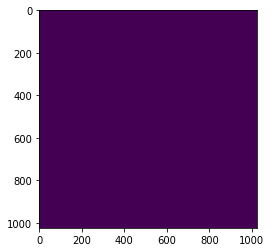

In [44]:
plt.imshow(building_mask_pred ^ train);